In [1]:
import netgen.gui
%gui tk
from ngsolve import *
from netgen.geom2d import SplineGeometry
#from scipy.special import jv
import matplotlib.pyplot as plt

Complex-valued waves
====


In NGSolve finite element spaces can be built and linear systems can be solved over the complex field. This tutorial shows how to compute the solution of the Helmholtz equation with impedance boundary conditions in complex arithmetic. The boundary value problem is to find $u$ satisfying 
$$
-\Delta u - \omega^2 u = f\qquad \text{ in } \Omega
$$
together with the impedance (outgoing) boundary condition
$$
\frac{\partial u }{ \partial n} - i \omega u = 0 
\quad \text{ on } \partial \Omega
$$
where $i = $`1j` is the imaginary unit.



In [2]:
# Geometry 
geo = SplineGeometry()
geo.AddCircle((0.5, 0.5), 0.8,  bc="outer")
geo.AddRectangle((0.7, 0.3), (0.75, 0.7),
                 leftdomain=0, rightdomain=1, bc="scat")
mesh = Mesh(geo.GenerateMesh(maxh=0.05))

### Declare  a complex finite element space 

In [3]:
fes = H1(mesh, order=5, complex=True)
u, v = fes.TnT()

In [4]:
# Wavenumber & source
omega = 100
pulse = 1e3*exp(-(100**2)*((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5)))
Draw(pulse, mesh, 'pulse')

### Forming the system

The weak form for $u \in H^1$:
$$
\int_\Omega\big[ \nabla u \cdot \nabla \bar v - \omega^2 u \bar v \big]
\, dx - 
i \,\omega\, \int_{\partial \Omega} u \bar v \, ds = \int_{\Omega} f \bar v
$$
for all $v$ in $H^1$. 

In [5]:
# Forms
a = BilinearForm(fes)
a += SymbolicBFI(grad(u)*grad(v)-omega**2*u*v)
a += SymbolicBFI(-omega*1j*u*v, definedon=mesh.Boundaries("outer"))
a.Assemble()

f = LinearForm(fes)
f += SymbolicLFI(pulse * v)
f.Assemble()

### Solve

In [6]:
gfu = GridFunction(fes, name="u")
gfu.vec.data = a.mat.Inverse() * f.vec
Draw(gfu)

Explore the GUI's menu options in `Visual` tab:
    - Increase subdivions
    - Real and imaginary parts
    - View absolute value
    - Turn off Autoscale
    - Turn on Deformation
    - Turn on Periodic Animation


# Comparison to exact solution
The boundary value problem is to find $u$ satisfying 
$$
-\Delta u - \omega^2 u = 0\qquad \text{ in } \Omega
$$
together with the impedance (outgoing) boundary condition
$$
\frac{\partial u }{ \partial n} - i \omega u = g
\quad \text{ on } \partial \Omega
$$
with $ g(x)=H_0^{(1)}(\omega\sqrt{(x_1-0.5)^2+(x_2-0.5)^2}) $, the Hankel function of first kind.

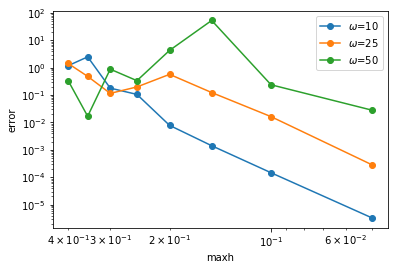

In [24]:
from netgen.geom2d import unit_square
import ngsolve.special_functions

#exact_sol = ngsolve.special_functions.jv(z=omega*sqrt((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5)), v=0)
#grad_exact_1 = -omega*(x-0.5) * ngsolve.special_functions.jv(z=omega*sqrt((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5)), v=1)/sqrt((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5))
#grad_exact_2 = -omega*(y-0.5) * ngsolve.special_functions.jv(z=omega*sqrt((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5)), v=1)/sqrt((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5))
#Draw(exact_sol,mesh,'e')

maxh = [0.4-j*0.05 for j in range(0,8)]
error = [0] * len(maxh)

fig = plt.figure()
for omega in [10,25,50]:
    exact_sol = exp(-1j*omega*(sqrt(0.7)*x+sqrt(0.3)*y))
    for i,h in enumerate(maxh):
        mesh = Mesh(unit_square.GenerateMesh(maxh=h))
        fes = H1(mesh, order=3, complex=True, dirichlet="left|right|top|bottom")
        u, v = fes.TnT()
        n = specialcf.normal(2)

        a = BilinearForm(fes)
        a += SymbolicBFI(grad(u)*grad(v)-omega**2*u*v)
        a += SymbolicBFI(-omega*1j*u*v, definedon=mesh.Boundaries("outer"))
        a.Assemble()
        gfu = GridFunction(fes)
        gfu.Set(exact_sol,BND)
        r = gfu.vec.CreateVector()
        r.data = -a.mat*gfu.vec
        gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
        Draw(gfu,mesh,'gfu')

        error[i] = sqrt(Integrate((exact_sol-gfu)*(exact_sol-gfu),mesh)).real
    plt.loglog(maxh , error, '-o', label="$\omega$="+str(omega))
        
plt.gca().invert_xaxis()
plt.ylabel("error")
plt.xlabel("maxh")
plt.legend()
plt.show()
#plt.draw()